In [1]:
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import when,mean,round,rank,sum,col
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression,GBTClassifier, GBTClassificationModel ,LogisticRegressionModel
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

In [2]:
findspark.init('/opt/cloudera/parcels/SPARK2/lib/spark2')

In [3]:
spark = SparkSession.builder.master('local[*]').appName('imbalanced_binary_classification').config('spark.kryoserializer.buffer.max', '1024').getOrCreate()
new_df = spark.read.csv('file:///04_spark_ml/data/classification/application_train.csv', header=True, inferSchema=True)
new_df = new_df.rdd.repartition(8).toDF()
new_df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [4]:
drop_col = ['SK_ID_CURR']
new_df = new_df.select([column for column in new_df.columns if column not in drop_col])
new_df = new_df.withColumnRenamed('TARGET', 'label')
new_df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


307511


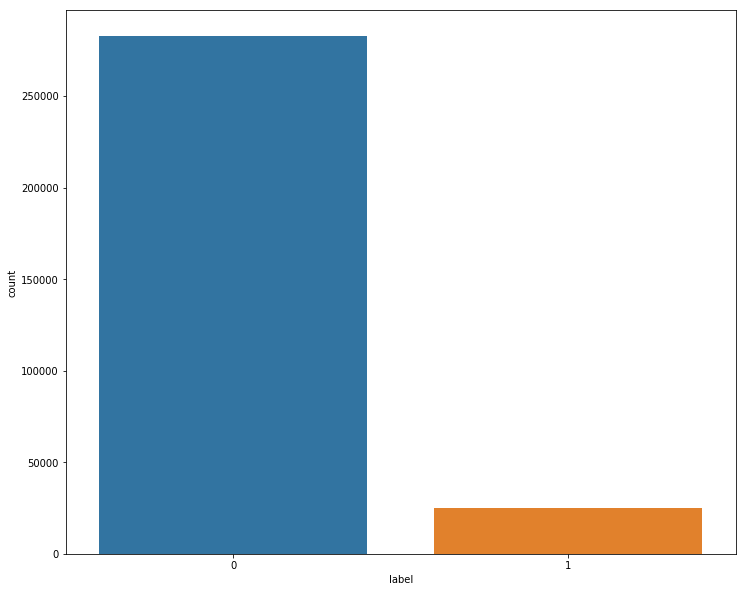

In [5]:
%matplotlib inline
df_pd = new_df.toPandas()
print(len(df_pd))
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)

In [6]:
pd.DataFrame(new_df.take(10), columns= new_df.columns)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
for i in new_df.dtypes:
    print(i)

('label', 'int')
('NAME_CONTRACT_TYPE', 'string')
('CODE_GENDER', 'string')
('FLAG_OWN_CAR', 'string')
('FLAG_OWN_REALTY', 'string')
('CNT_CHILDREN', 'int')
('AMT_INCOME_TOTAL', 'double')
('AMT_CREDIT', 'double')
('AMT_ANNUITY', 'double')
('AMT_GOODS_PRICE', 'double')
('NAME_TYPE_SUITE', 'string')
('NAME_INCOME_TYPE', 'string')
('NAME_EDUCATION_TYPE', 'string')
('NAME_FAMILY_STATUS', 'string')
('NAME_HOUSING_TYPE', 'string')
('REGION_POPULATION_RELATIVE', 'double')
('DAYS_BIRTH', 'int')
('DAYS_EMPLOYED', 'int')
('DAYS_REGISTRATION', 'double')
('DAYS_ID_PUBLISH', 'int')
('OWN_CAR_AGE', 'double')
('FLAG_MOBIL', 'int')
('FLAG_EMP_PHONE', 'int')
('FLAG_WORK_PHONE', 'int')
('FLAG_CONT_MOBILE', 'int')
('FLAG_PHONE', 'int')
('FLAG_EMAIL', 'int')
('OCCUPATION_TYPE', 'string')
('CNT_FAM_MEMBERS', 'double')
('REGION_RATING_CLIENT', 'int')
('REGION_RATING_CLIENT_W_CITY', 'int')
('WEEKDAY_APPR_PROCESS_START', 'string')
('HOUR_APPR_PROCESS_START', 'int')
('REG_REGION_NOT_LIVE_REGION', 'int')
('REG_

In [8]:
cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')

num_cols = [item[0] for item in new_df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')

16  categorical features
104  numerical features


In [9]:
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() 
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)         
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") 
    return mis_val_table_ren_columns

In [10]:
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) #count percentage of null in each columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)         
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns

In [11]:
missings = info_missing_table(df_pd)
missings

Your selected dataframe has 121 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


In [12]:
def count_missings(spark_df):
    null_counts = []        
    for col in spark_df.dtypes:    
        cname = col[0]     
        ctype = col[1]      
        nulls = spark_df.where( spark_df[cname].isNull()).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts


In [13]:
miss_counts = count_missings(new_df)
miss_counts

[('AMT_ANNUITY', 12),
 ('AMT_GOODS_PRICE', 278),
 ('NAME_TYPE_SUITE', 1292),
 ('OWN_CAR_AGE', 202929),
 ('OCCUPATION_TYPE', 96391),
 ('CNT_FAM_MEMBERS', 2),
 ('EXT_SOURCE_1', 173378),
 ('EXT_SOURCE_2', 660),
 ('EXT_SOURCE_3', 60965),
 ('APARTMENTS_AVG', 156061),
 ('BASEMENTAREA_AVG', 179943),
 ('YEARS_BEGINEXPLUATATION_AVG', 150007),
 ('YEARS_BUILD_AVG', 204488),
 ('COMMONAREA_AVG', 214865),
 ('ELEVATORS_AVG', 163891),
 ('ENTRANCES_AVG', 154828),
 ('FLOORSMAX_AVG', 153020),
 ('FLOORSMIN_AVG', 208642),
 ('LANDAREA_AVG', 182590),
 ('LIVINGAPARTMENTS_AVG', 210199),
 ('LIVINGAREA_AVG', 154350),
 ('NONLIVINGAPARTMENTS_AVG', 213514),
 ('NONLIVINGAREA_AVG', 169682),
 ('APARTMENTS_MODE', 156061),
 ('BASEMENTAREA_MODE', 179943),
 ('YEARS_BEGINEXPLUATATION_MODE', 150007),
 ('YEARS_BUILD_MODE', 204488),
 ('COMMONAREA_MODE', 214865),
 ('ELEVATORS_MODE', 163891),
 ('ENTRANCES_MODE', 154828),
 ('FLOORSMAX_MODE', 153020),
 ('FLOORSMIN_MODE', 208642),
 ('LANDAREA_MODE', 182590),
 ('LIVINGAPARTMENTS_MO

In [14]:
list_cols_miss=[x[0] for x in miss_counts]
df_miss= new_df.select(*list_cols_miss)
#categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("cateogrical columns_miss:", catcolums_miss)

### numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
# print("numerical columns_miss:", numcolumns_miss)

cateogrical columns_miss: ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [15]:
df_Nomiss=new_df.na.drop()
for x in catcolums_miss:
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    print(x, mode) #print name of columns and it's most categories 
    new_df = new_df.na.fill({x:mode}) 

NAME_TYPE_SUITE Unaccompanied
OCCUPATION_TYPE Laborers
FONDKAPREMONT_MODE reg oper account
HOUSETYPE_MODE block of flats
WALLSMATERIAL_MODE Panel
EMERGENCYSTATE_MODE No


In [16]:
for i in numcolumns_miss:
    meanvalue = new_df.select(round(mean(i))).collect()[0][0] 
    print(i, meanvalue) 
    new_df=new_df.na.fill({i:meanvalue}) 

AMT_ANNUITY 27109.0
AMT_GOODS_PRICE 538396.0
OWN_CAR_AGE 12.0
CNT_FAM_MEMBERS 2.0
EXT_SOURCE_1 1.0
EXT_SOURCE_2 1.0
EXT_SOURCE_3 1.0
APARTMENTS_AVG 0.0
BASEMENTAREA_AVG 0.0
YEARS_BEGINEXPLUATATION_AVG 1.0
YEARS_BUILD_AVG 1.0
COMMONAREA_AVG 0.0
ELEVATORS_AVG 0.0
ENTRANCES_AVG 0.0
FLOORSMAX_AVG 0.0
FLOORSMIN_AVG 0.0
LANDAREA_AVG 0.0
LIVINGAPARTMENTS_AVG 0.0
LIVINGAREA_AVG 0.0
NONLIVINGAPARTMENTS_AVG 0.0
NONLIVINGAREA_AVG 0.0
APARTMENTS_MODE 0.0
BASEMENTAREA_MODE 0.0
YEARS_BEGINEXPLUATATION_MODE 1.0
YEARS_BUILD_MODE 1.0
COMMONAREA_MODE 0.0
ELEVATORS_MODE 0.0
ENTRANCES_MODE 0.0
FLOORSMAX_MODE 0.0
FLOORSMIN_MODE 0.0
LANDAREA_MODE 0.0
LIVINGAPARTMENTS_MODE 0.0
LIVINGAREA_MODE 0.0
NONLIVINGAPARTMENTS_MODE 0.0
NONLIVINGAREA_MODE 0.0
APARTMENTS_MEDI 0.0
BASEMENTAREA_MEDI 0.0
YEARS_BEGINEXPLUATATION_MEDI 1.0
YEARS_BUILD_MEDI 1.0
COMMONAREA_MEDI 0.0
ELEVATORS_MEDI 0.0
ENTRANCES_MEDI 0.0
FLOORSMAX_MEDI 0.0
FLOORSMIN_MEDI 0.0
LANDAREA_MEDI 0.0
LIVINGAPARTMENTS_MEDI 0.0
LIVINGAREA_MEDI 0.0
NONLIVING

In [17]:
ratio = 0.91
def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))

new_df = new_df.withColumn('weights', weight_balance(col('label')))

In [18]:
new_df.limit(10).toPandas()

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,weights
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.91
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.09
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,0.09
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.09
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09


In [19]:
miss_counts2 = count_missings(new_df)
miss_counts2

[]

In [20]:
pd.DataFrame(new_df.take(10), columns= new_df.columns)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,weights
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.91
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.09
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,0.09
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.09
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09


In [21]:
stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [22]:
cols = new_df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)
new_df = pipelineModel.transform(new_df)

In [23]:
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)
pd.DataFrame(new_df.take(5), columns=new_df.columns)

,features,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,weights
0,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.91
1,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
2,"(0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
3,"(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09
4,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09


In [24]:
train, test = new_df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())

246015
61496


## Training models

In [25]:
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

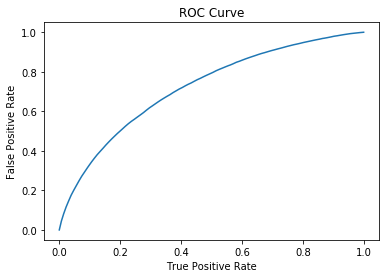

Training set ROC: 0.72027617353729


In [26]:
trainingSummary = LR_model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [28]:
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET Area Under ROC: " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test_SET Area Under ROC: 0.7193116947056014


In [27]:
gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)
predictions = GBT_Model.transform(test)

In [29]:
evaluator = BinaryClassificationEvaluator()
print("Test_SET Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test_SET Area Under ROC: 0.7327279183494619


In [28]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 30])
             .addGrid(gbt.maxIter, [10, 15])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.7359447736913467

In [50]:
cvModel.bestModel.write().overwrite().save('gbt_model')

In [74]:
LR_model.write().overwrite().save('lr_model')
LR_model2 = LogisticRegressionModel.load('lr_model/')
predictions_LR2 = LR_model2.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET Area Under ROC: " + str(evaluator.evaluate(predictions_LR2, {evaluator.metricName: "areaUnderROC"})))

Test_SET Area Under ROC: 0.719311694705599


In [75]:
cvModel.bestModel.write().overwrite().save('gbt_model')
gbt_model2 = GBTClassificationModel.load('gbt_model/')
gbt_model2.explainParams()
predictions_gbt2 = gbt_model2.transform(test)
evaluator.evaluate(predictions_gbt2)

0.7359447736913439